In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
from joblib import load
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from scipy.stats import pearsonr
from tqdm import tqdm
from __future__ import division
import numpy as np
import pandas as pd
import math as math
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, ConstantKernel as C
from sklearn.gaussian_process.kernels import WhiteKernel
from sklearn.model_selection import train_test_split
from sklearn.gaussian_process.kernels import Matern, RationalQuadratic,ExpSineSquared,PairwiseKernel
from tqdm import tqdm
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from scipy.stats import pearsonr
from sklearn.model_selection import KFold
from sklearn.gaussian_process.kernels import (StationaryKernelMixin,NormalizedKernelMixin,Kernel,Hyperparameter,squareform,pdist,cdist)
import scipy.spatial.distance as distance
import joblib
import matplotlib.pyplot as plt
import os

In [4]:
columns = ["x","y","z","w","data","error"]
datatab = pd.read_table(r"C:\Users\seanw\OneDrive\Desktop\GitHub\FYP\Data\Updateddata.txt",names = columns)
datatab
x = datatab['x']
y = datatab['y']
z = datatab['z']
w = datatab['w']
data = datatab['data']
error = datatab['error']

# First Mass
datam1 = datatab[0:250]
xm1 = datam1['x'].values
ym1 = datam1['y'].values
zm1 = datam1['z'].values
wm1 = datam1['w'].values
dm1 = datam1['data'].values
em1 = datam1['error'].values
X1 = np.column_stack((xm1, ym1, zm1, wm1))

# Second Mass
datam2 = datatab[250:500]
xm2 = datam2['x'].values
ym2 = datam2['y'].values
zm2 = datam2['z'].values
wm2 = datam2['w'].values
dm2 = datam2['data'].values
em2 = datam2['error'].values
X2 = np.column_stack((xm2, ym2, zm2, wm2))

# Third Mass
datam3 = datatab[500:750]
xm3 = datam3['x'].values
ym3 = datam3['y'].values
zm3 = datam3['z'].values
wm3 = datam3['w'].values
dm3 = datam3['data'].values
em3 = datam3['error'].values
X3 = np.column_stack((xm3, ym3, zm3, wm3))

# Fourth Mass
datam4 = datatab[750:]
xm4 = datam4['x'].values
ym4 = datam4['y'].values
zm4 = datam4['z'].values
wm4 = datam4['w'].values
dm4 = datam4['data'].values
em4 = datam4['error'].values
X4 = np.column_stack((xm4, ym4, zm4, wm4))

X = np.column_stack((x,y, z, w))
D = np.concatenate((dm1,dm2,dm3,dm4))
E = np.concatenate((em1,em2,em3,em4))

In [5]:
indices = np.arange(X.shape[0])
X_trainval, X_test, D_trainval, D_test, E_trainval, E_test, indices_trainval, indices_test = train_test_split(X, D,E,indices, test_size=0.1, random_state=42)

Processing kernels: 100%|██████████| 8/8 [00:01<00:00,  7.42it/s]


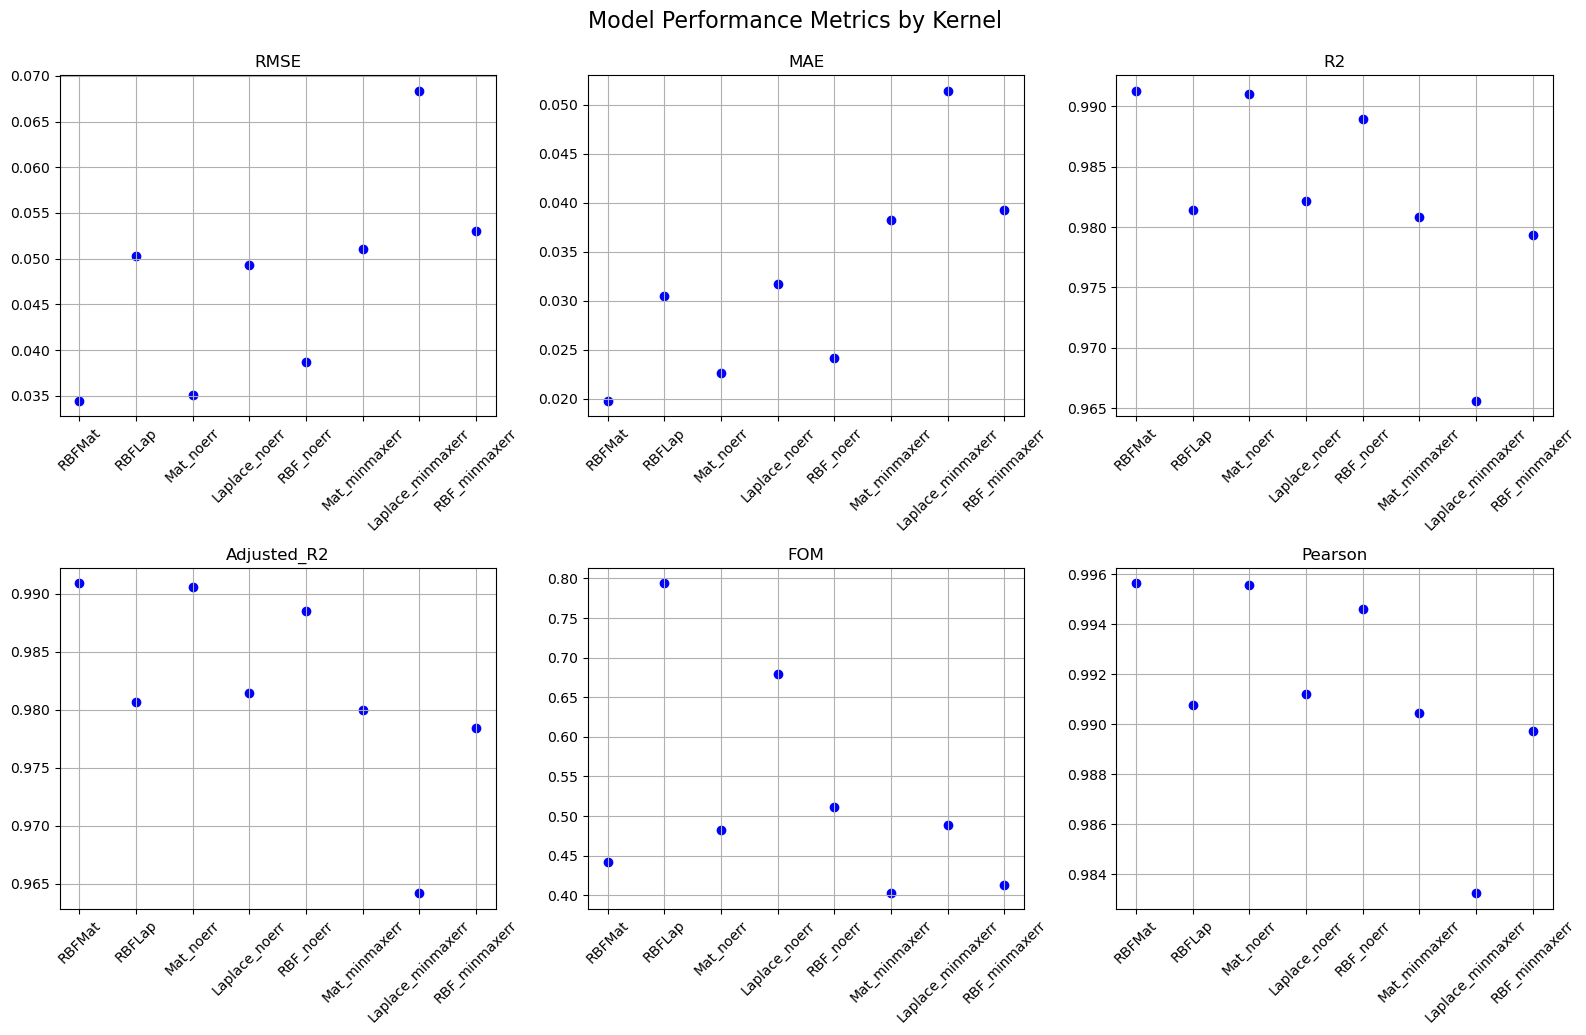

In [6]:
base_dir = r'C:\Users\seanw\OneDrive\Desktop\GitHub\FYP\Final_gps'

# Define only kernel names (used to load from disk)
kernel_names = [
    "RBFMat",
    "RBFLap",
    "Mat_noerr",
    "Laplace_noerr",
    "RBF_noerr",
    "Mat_minmaxerr",
    "Laplace_minmaxerr",
    "RBF_minmaxerr"
]

metrics = {"RMSE": {}, "MAE": {}, "R2": {}, "Adjusted_R2": {}, "FOM": {}, "Pearson":{} }

# Compute metrics
for kernel_name in tqdm(kernel_names, desc="Processing kernels"):
    model_path = os.path.join(base_dir, f'GPR_{kernel_name}.joblib')
    gpr_loaded = load(model_path)

    mean_pred, std_pred = gpr_loaded.predict(X_test, return_std=True)

    rmse = np.sqrt(mean_squared_error(D_test, mean_pred))
    mae = mean_absolute_error(D_test, mean_pred)
    r2 = r2_score(D_test, mean_pred)
    adj_r2 = 1 - (1 - r2) * (len(D_test) - 1) / (len(D_test) - X_test.shape[1] - 1)
    fom = np.mean(np.abs(D_test - mean_pred) / std_pred)
    pearson, _ = pearsonr(D_test.ravel(), mean_pred.ravel())

    # Store metrics
    metrics["RMSE"][kernel_name] = rmse
    metrics["MAE"][kernel_name] = mae
    metrics["R2"][kernel_name] = r2
    metrics["Adjusted_R2"][kernel_name] = adj_r2
    metrics["FOM"][kernel_name] = fom
    metrics["Pearson"][kernel_name] = pearson

# Plot
fig, axs = plt.subplots(2, 3, figsize=(16, 10))
axs = axs.ravel()

for i, (metric_name, metric_values) in enumerate(metrics.items()):
    axs[i].scatter(list(metric_values.keys()), list(metric_values.values()), color='blue')
    axs[i].set_title(metric_name)
    axs[i].tick_params(axis='x', rotation=45)
    axs[i].grid(True)

plt.tight_layout()
plt.suptitle("Model Performance Metrics by Kernel", fontsize=16, y=1.03)
#plt.savefig(r"C:\Users\seanw\OneDrive\Desktop\GitHub\FYP\latex\LatexPlots\final_gps_plots\metrics_of_finalists", dpi=72, bbox_inches='tight')
plt.show()



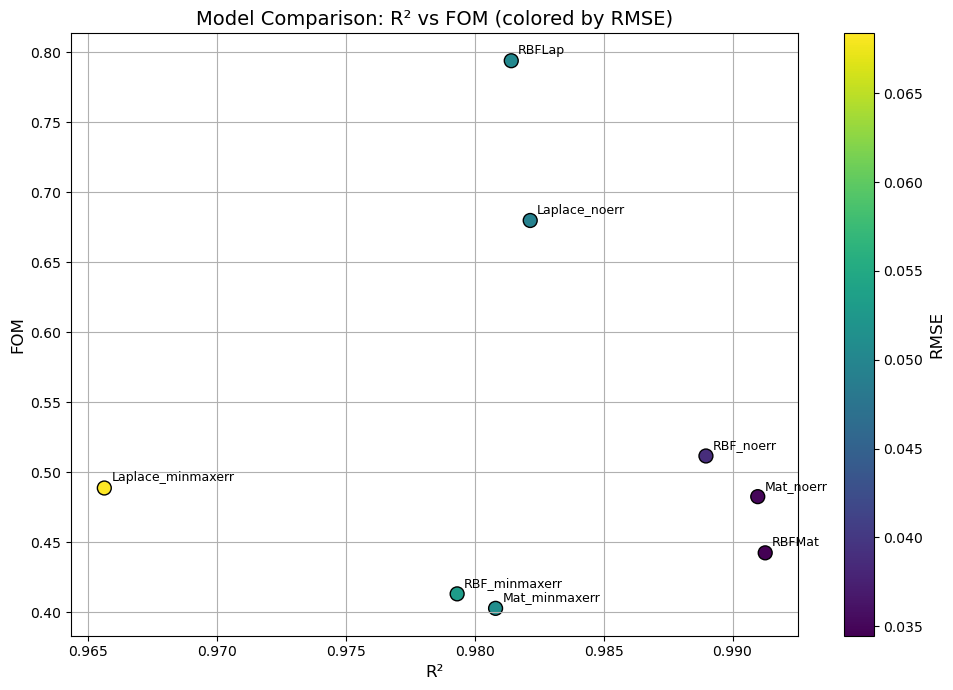

In [ ]:
# Extract values
kernel_names = list(metrics["R2"].keys())
r2_values = [metrics["R2"][name] for name in kernel_names]
fom_values = [metrics["FOM"][name] for name in kernel_names]
rmse_values = [metrics["RMSE"][name] for name in kernel_names]

# Scatter plot
plt.figure(figsize=(10, 7))
sc = plt.scatter(r2_values, fom_values, c=rmse_values, cmap='viridis', s=100, edgecolor='k')

# Add colorbar
cbar = plt.colorbar(sc)
cbar.set_label('RMSE', fontsize=12)

# Annotate points
for i, name in enumerate(kernel_names):
    plt.annotate(name, (r2_values[i], fom_values[i]), fontsize=9, xytext=(5, 5), textcoords='offset points')

# Labels and title
plt.xlabel("R²", fontsize=12)
plt.ylabel("FOM", fontsize=12)
plt.title("Model Comparison: R² vs FOM (colored by RMSE)", fontsize=14)
plt.grid(True)
plt.tight_layout()
##plt.savefig(r"C:\Users\seanw\OneDrive\Desktop\GitHub\FYP\latex\LatexPlots\final_gps_plots\metric_of_finalists_comparison",dpi=72, bbox_inches='tight')
plt.show()

Plotting each kernel: 100%|██████████| 8/8 [00:09<00:00,  1.20s/it]


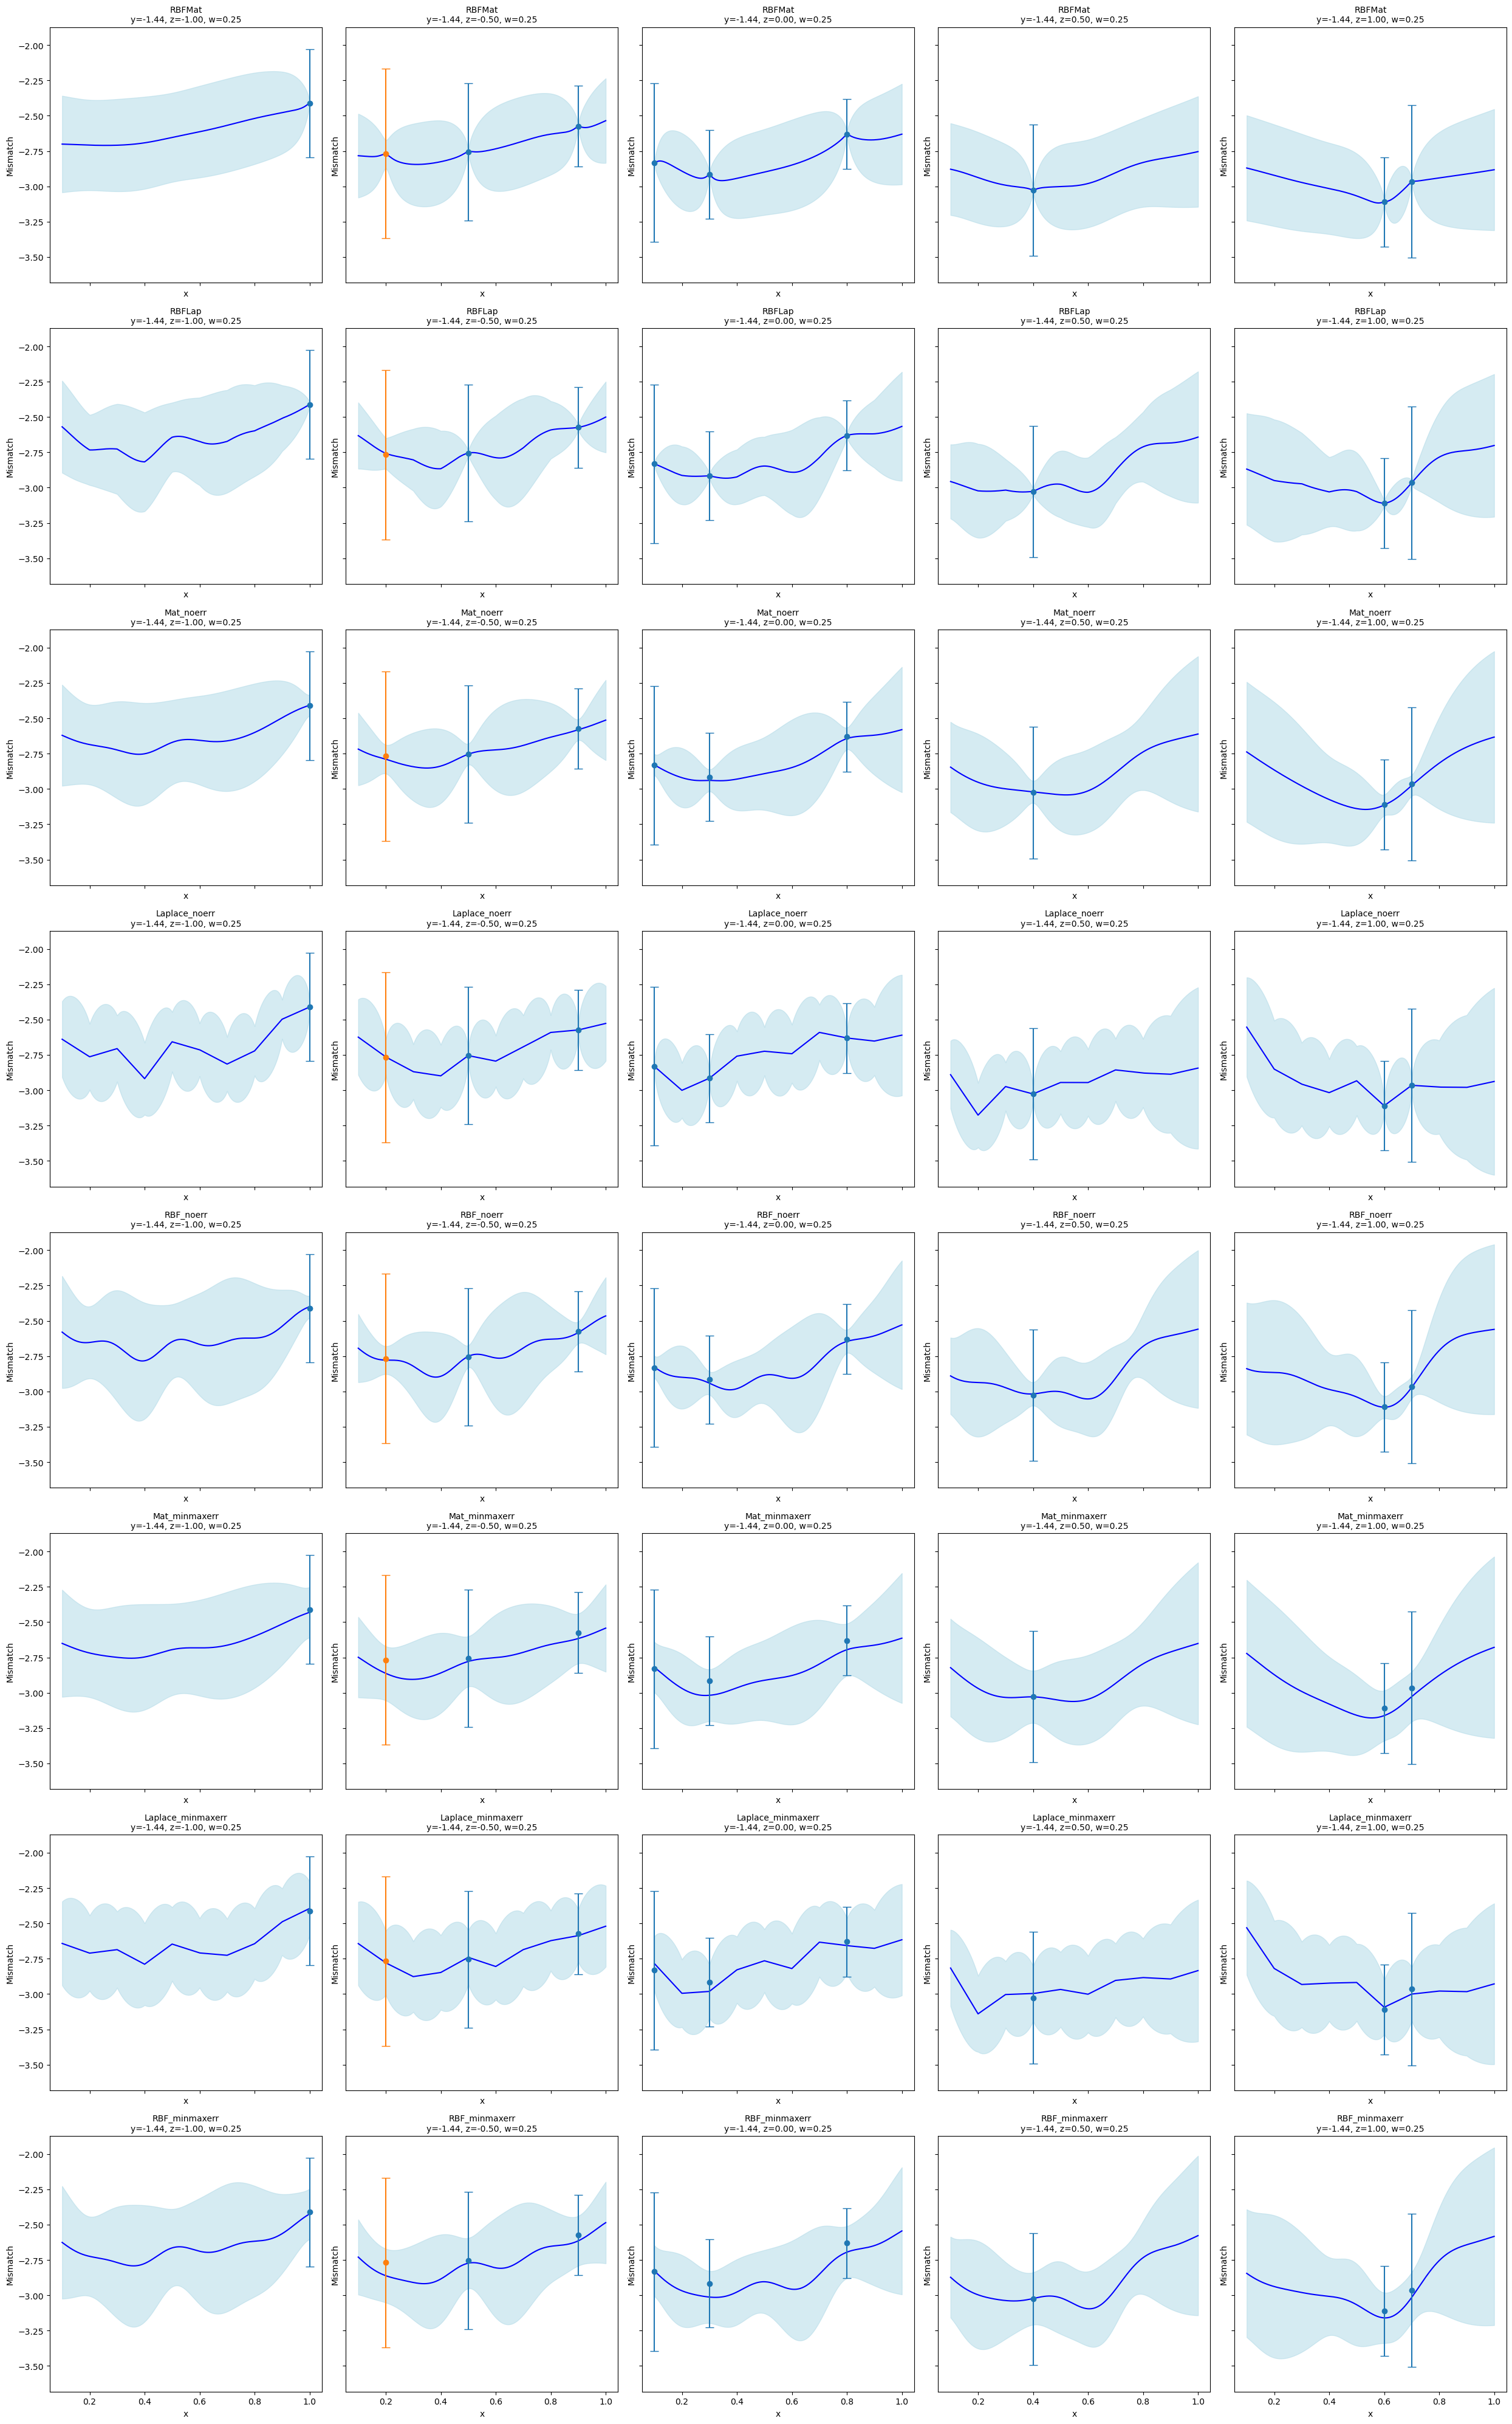

In [ ]:
train1indices = indices_trainval[indices_trainval <= 249]
test1indices = indices_test[indices_test <= 249]
X1_train = X[train1indices]
X1_test = X[test1indices]
D1_train = D[train1indices]
D1_test = D[test1indices]
E1_train = E[train1indices]
E1_test = E[test1indices]


x1train, y1train, z1train = X1_train[:, 0], X1_train[:, 1], X1_train[:, 2]
x1test,  y1test,  z1test  = X1_test[:, 0],  X1_test[:, 1],  X1_test[:, 2]


xdomain = np.linspace(0.1, 1, 1000)
ydomain = np.linspace(-np.pi/2, np.pi/2, 1000)
zpoints = np.linspace(-1, 1, 5)
xpoints = np.linspace(0.1, 1, 10)
ypoints = np.linspace(-np.pi/2, np.pi/2, 25)
wpoints = np.linspace(0.25, 1, 4)

i = 1  # index for ypoint
j = 0  # index for wpoint
ypoint = ypoints[i]
wpoint = wpoints[j]

# # Model names only
# kernel_names = [
#     "RBFMat", "RBFLap", "Mat_noerr", "Laplace_noerr",
#     "RBF_noerr", "Mat_minmaxerr", "Laplace_minmaxerr", "RBF_minmaxerr"
# ]

# Plotting
num_kernels = len(kernel_names)
fig, axes = plt.subplots(nrows=num_kernels, ncols=5, figsize=(25, 5 * num_kernels), sharex=True, sharey=True)

for row, kernel_name in enumerate(tqdm(kernel_names, desc="Plotting each kernel")):
    # Load model
    model_path = os.path.join(base_dir, f'GPR_{kernel_name}.joblib')
    gpr_loaded = load(model_path)

    for col, zpoint in enumerate(zpoints):
        ax = axes[row, col]
        
        # Create prediction inputs (x varies, others fixed)
        Xpred = np.column_stack((
            xdomain,
            np.full_like(xdomain, ypoint),
            np.full_like(xdomain, zpoint),
            np.full_like(xdomain, wpoint)
        ))

        # Predict
        pred_mean, pred_std = gpr_loaded.predict(Xpred, return_std=True)

        # Plot mean and confidence interval
        ax.plot(xdomain, pred_mean, color='blue')
        ax.fill_between(xdomain, pred_mean - 2 * pred_std, pred_mean + 2 * pred_std, color='lightblue', alpha=0.5)

        # Filter training/test points near y and z
        indtrain = np.isclose(y1train, ypoint, atol=0.05) & np.isclose(z1train, zpoint, atol=0.05)
        indtest = np.isclose(y1test, ypoint, atol=0.05) & np.isclose(z1test, zpoint, atol=0.05)

        # Overlay points
        ax.errorbar(x1train[indtrain], D1_train[indtrain], yerr=E1_train[indtrain], fmt='o', color='#1f77b4', capsize=5)
        ax.errorbar(x1test[indtest],  D1_test[indtest],   yerr=E1_test[indtest],  fmt='o', color='#ff7f0e', capsize=5)

        # Label
        ax.set_title(f"{kernel_name}\ny={ypoint:.2f}, z={zpoint:.2f}, w={wpoint:.2f}", fontsize=10)
        ax.set_xlabel("x")
        ax.set_ylabel("Mismatch")

plt.tight_layout()
# plt.savefig("your_path_here.png", dpi=72, bbox_inches='tight')
plt.show()


Processing kernels: 100%|██████████| 8/8 [00:09<00:00,  1.20s/it]


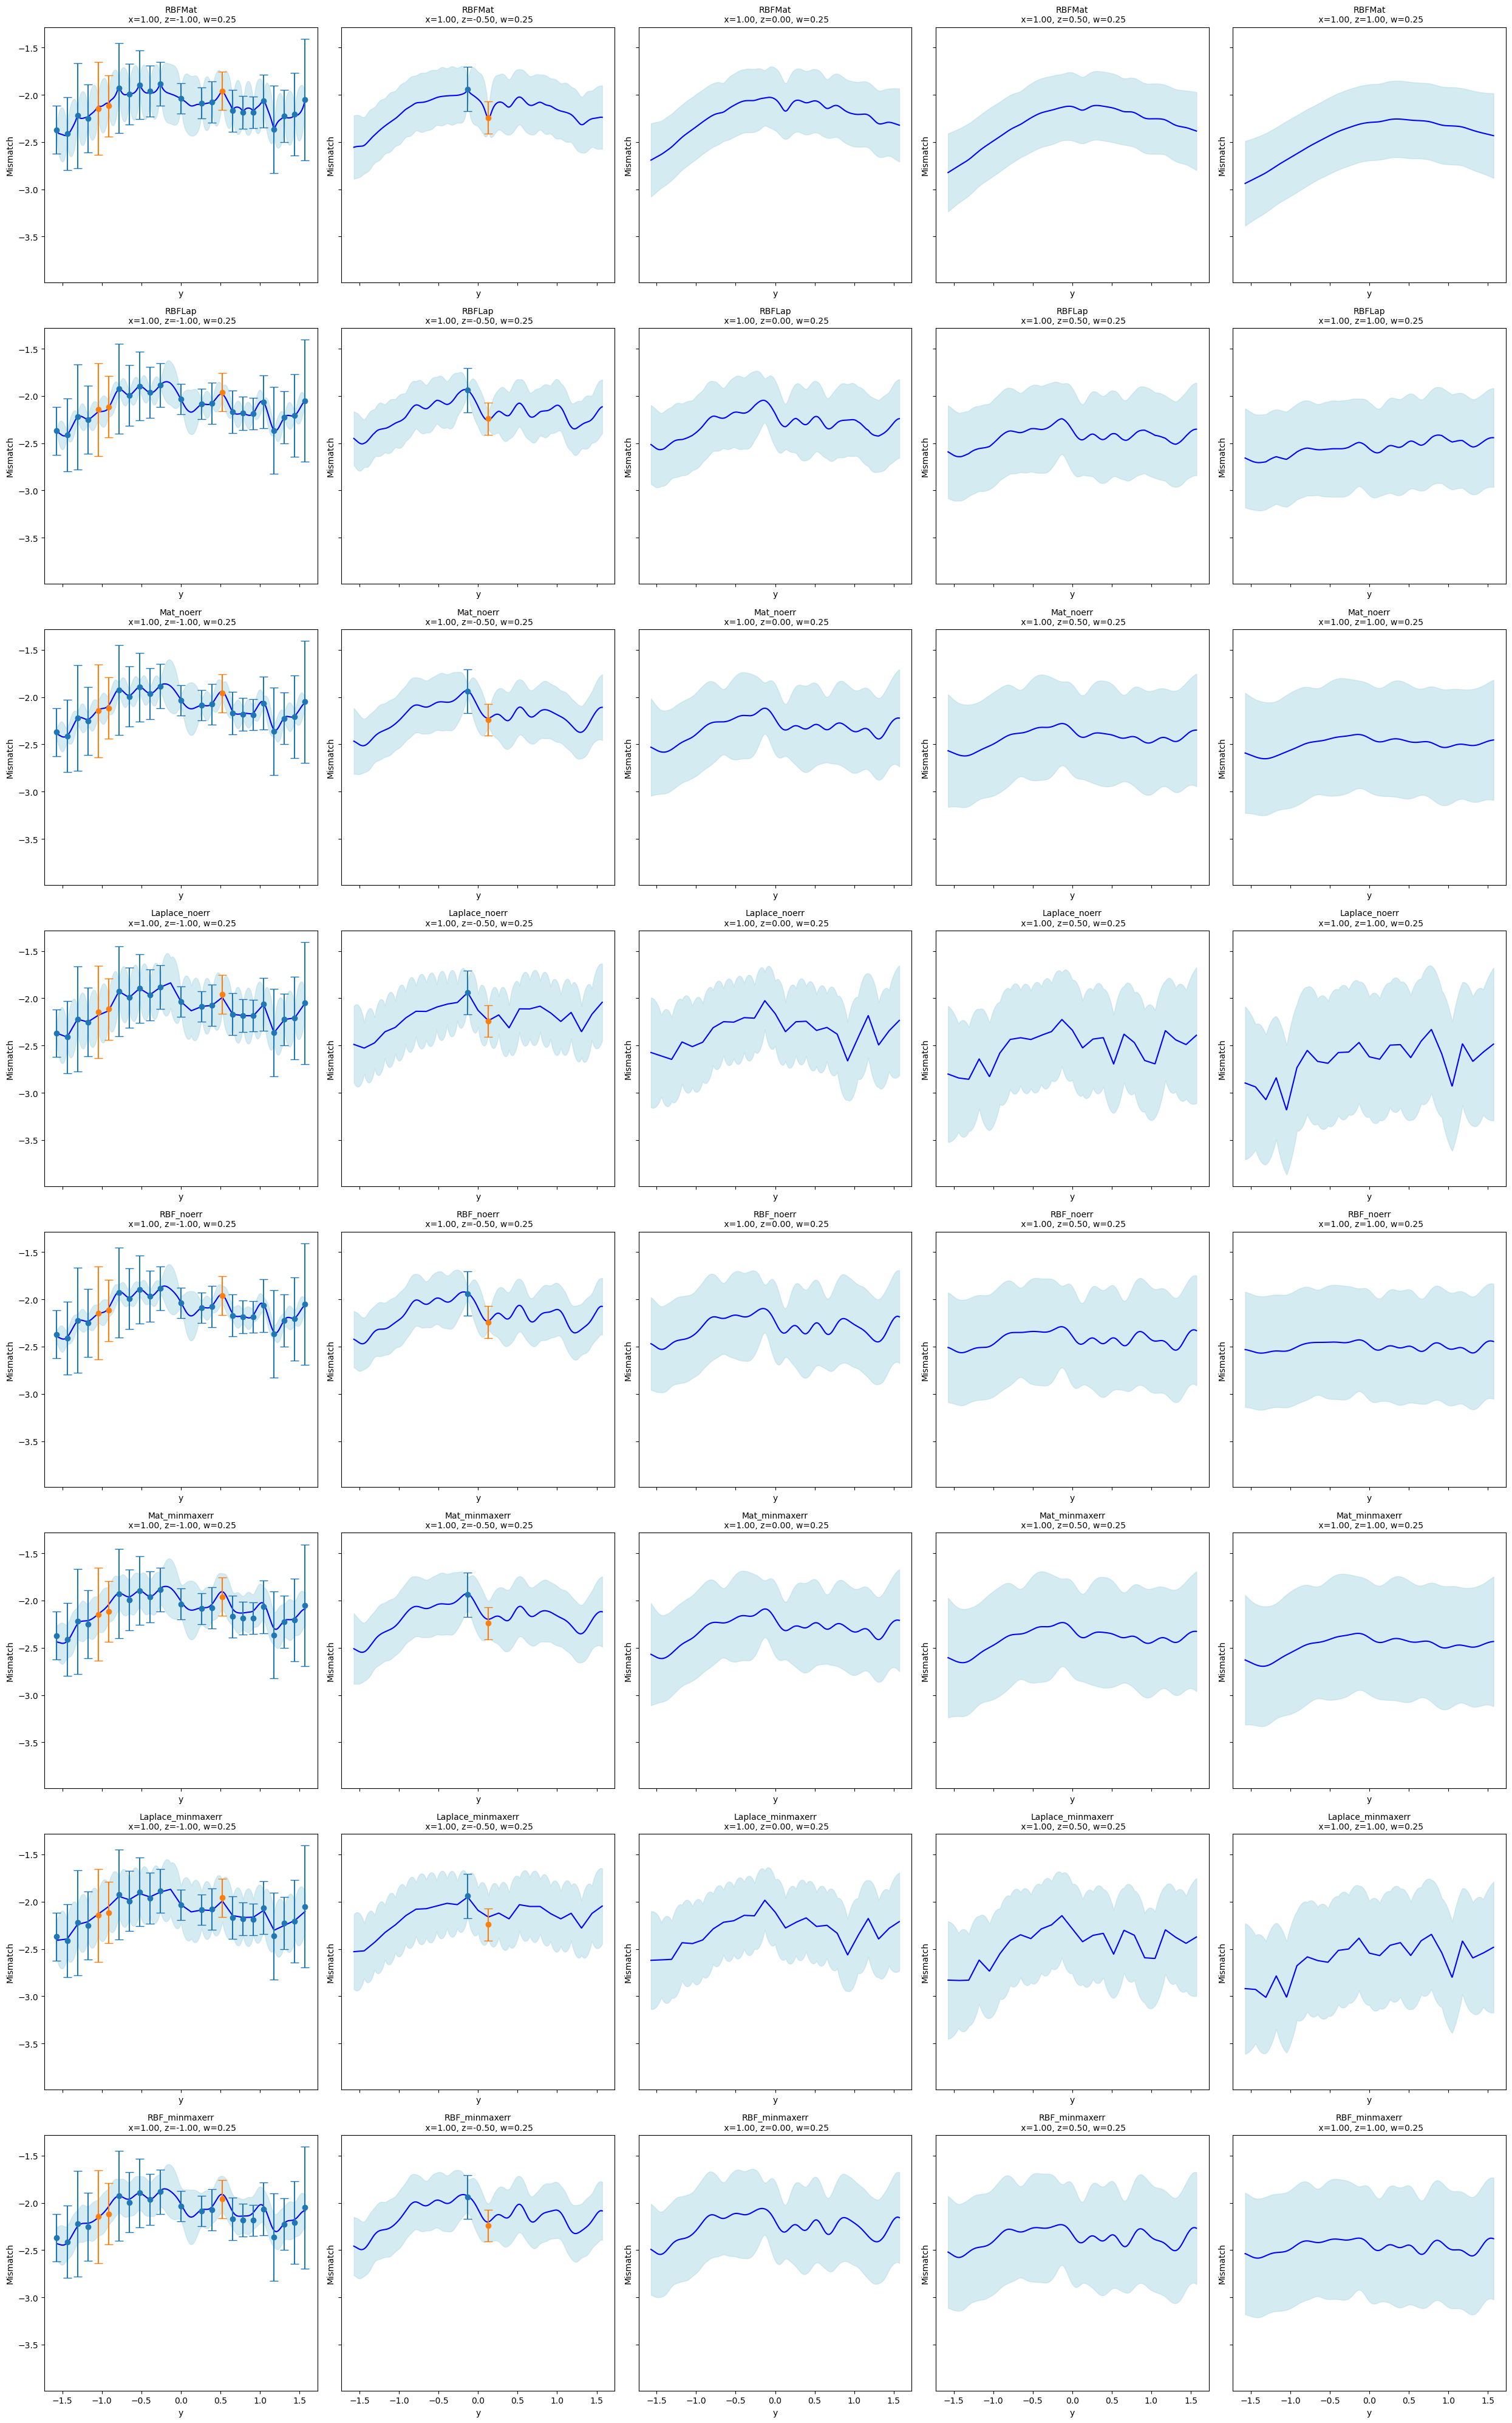

In [11]:
# Data filtering: Only use indices <= 249
train1indices = indices_trainval[indices_trainval <= 249]
test1indices = indices_test[indices_test <= 249]
X1_train = X[train1indices]
X1_test = X[test1indices]
D1_train = D[train1indices]
D1_test = D[test1indices]
E1_train = E[train1indices]
E1_test = E[test1indices]

# Extract columns
x1train, y1train, z1train = X1_train[:, 0], X1_train[:, 1], X1_train[:, 2]
x1test,  y1test,  z1test  = X1_test[:, 0],  X1_test[:, 1],  X1_test[:, 2]

# Define the input domains
xdomain = np.linspace(0.1, 1, 1000)
ydomain = np.linspace(-np.pi/2, np.pi/2, 1000)
zpoints = np.linspace(-1, 1, 5)
xpoints = np.linspace(0.1, 1, 10)
ypoints = np.linspace(-np.pi/2, np.pi/2, 25)
wpoints = np.linspace(0.25, 1, 4)

i = 9  # index for xpoint
xpoint = xpoints[i]
j = 0  # index for wpoint
wpoint = wpoints[j]


# Plotting setup
num_kernels = len(kernel_names)
fig, axes = plt.subplots(nrows=num_kernels, ncols=5, figsize=(25, 5 * num_kernels), sharex=True, sharey=True)

for row, kernel_name in enumerate(tqdm(kernel_names, desc="Processing kernels")):
    model_path = os.path.join(base_dir, f'GPR_{kernel_name}.joblib')
    gpr_loaded = load(model_path)

    for col, zpoint in enumerate(zpoints):
        ax = axes[row, col]

        # Predict over y-axis, keeping x, z, w fixed
        Xpred = np.column_stack((
            np.full_like(ydomain, xpoint),
            ydomain,
            np.full_like(ydomain, zpoint),
            np.full_like(ydomain, wpoint)
        ))

        pred_mean, pred_std = gpr_loaded.predict(Xpred, return_std=True)

        ax.plot(ydomain, pred_mean, color='blue')
        ax.fill_between(ydomain, pred_mean - 2 * pred_std, pred_mean + 2 * pred_std, color='lightblue', alpha=0.5)

        # Nearby training/test points
        indtrain = np.isclose(x1train, xpoint, atol=0.05) & np.isclose(z1train, zpoint, atol=0.05)
        indtest = np.isclose(x1test, xpoint, atol=0.05) & np.isclose(z1test, zpoint, atol=0.05)

        ax.errorbar(y1train[indtrain], D1_train[indtrain], yerr=E1_train[indtrain], fmt='o', color='#1f77b4', capsize=5)
        ax.errorbar(y1test[indtest],  D1_test[indtest],  yerr=E1_test[indtest],  fmt='o', color='#ff7f0e', capsize=5)

        ax.set_title(f"{kernel_name}\n x={xpoint:.2f}, z={zpoint:.2f}, w={wpoint:.2f}", fontsize=10)
        ax.set_xlabel("y")
        ax.set_ylabel("Mismatch")

plt.tight_layout()
#plt.savefig(r"C:\Users\seanw\OneDrive\Desktop\GitHub\FYP\latex\LatexPlots\final_gps_plots\final_gps_xcuts", dpi=72, bbox_inches='tight')
plt.show()


Kernel used: 1.53**2 * RBF(length_scale=[1, 1.51, 1.38, 1.36]) + 0.455**2 * Matern(length_scale=[0.0996, 0.0582, 0.414, 2.31], nu=0.75)


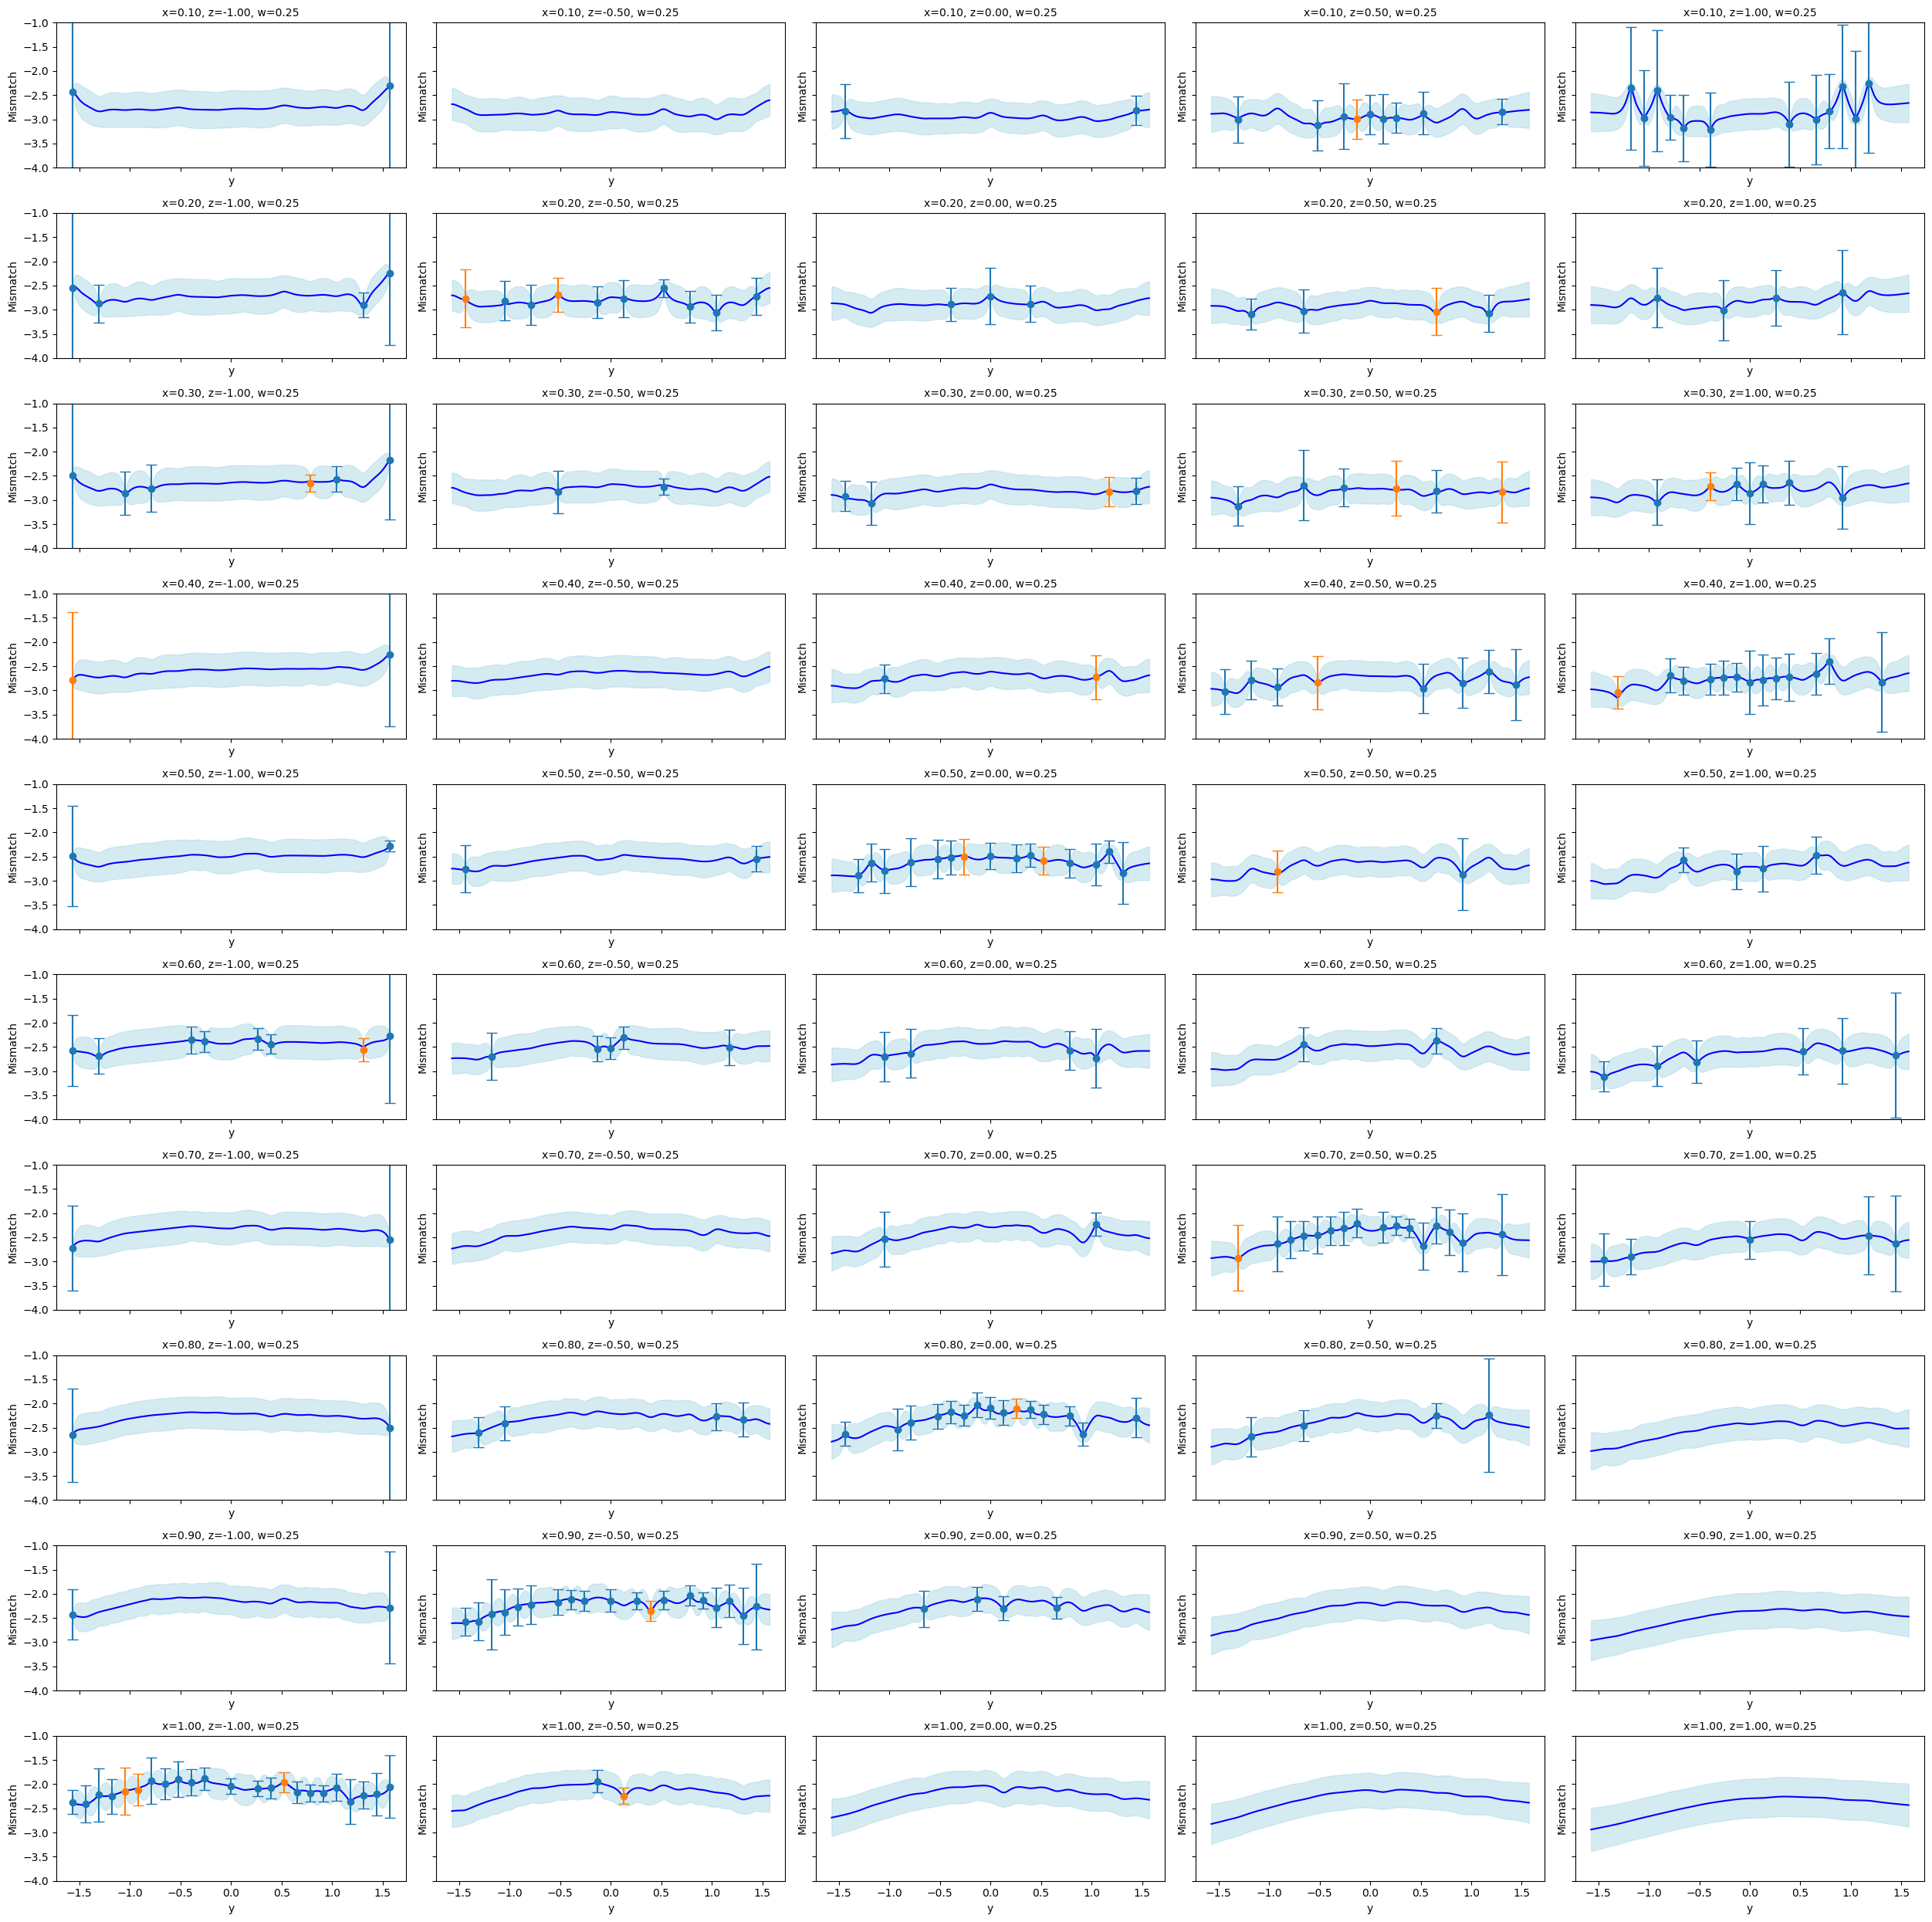

In [13]:
# Filter dataset to indices <= 249
train1indices = indices_trainval[indices_trainval <= 249]
test1indices = indices_test[indices_test <= 249]

X1_train, X1_test = X[train1indices], X[test1indices]
D1_train, D1_test = D[train1indices], D[test1indices]
E1_train, E1_test = E[train1indices], E[test1indices]

# Extract relevant coordinates
x1train, y1train, z1train = X1_train[:, 0], X1_train[:, 1], X1_train[:, 2]
x1test,  y1test,  z1test  = X1_test[:, 0],  X1_test[:, 1],  X1_test[:, 2]

# Define domains
xdomain = np.linspace(0.1, 1, 1000)
ydomain = np.linspace(-np.pi/2, np.pi/2, 1000)
zpoints = np.linspace(-1, 1, 5)
xpoints = np.linspace(0.1, 1, 10)
xpoints_plot = np.array([xpoints[0], xpoints[2], xpoints[4], xpoints[6], xpoints[9]])
wpoints = np.linspace(0.25, 1, 4)

# Choose w value
wpoint = wpoints[0]

# Load RBFMat model
model_path = os.path.join(base_dir, 'GPR_RBFMat.joblib')
gpr_loaded = load(model_path)
print("Kernel used:", gpr_loaded.kernel_)

# Set up figure
fig, axes = plt.subplots(nrows=10, ncols=5, figsize=(25, 25), sharex=True, sharey=True)

# Generate subplots
for row, xpoint in enumerate(xpoints):
    for col, zpoint in enumerate(zpoints):
        ax = axes[row, col]

        # Build prediction input
        Xpred = np.column_stack((
            np.full(ydomain.shape, xpoint),
            ydomain,
            np.full(ydomain.shape, zpoint),
            np.full(ydomain.shape, wpoint)
        ))

        pred_mean, pred_std = gpr_loaded.predict(Xpred, return_std=True)

        # Plot prediction
        ax.plot(ydomain, pred_mean, color='blue')
        ax.fill_between(ydomain, pred_mean - 2 * pred_std, pred_mean + 2 * pred_std, color='lightblue', alpha=0.5)

        # Filter data near x/z cut
        indtrain = np.isclose(x1train, xpoint, atol=0.05) & np.isclose(z1train, zpoint, atol=0.05)
        indtest  = np.isclose(x1test,  xpoint, atol=0.05) & np.isclose(z1test,  zpoint, atol=0.05)

        # Overlay points
        ax.errorbar(y1train[indtrain], D1_train[indtrain], yerr=E1_train[indtrain],
                    fmt='o', capsize=5, color='#1f77b4')
        ax.errorbar(y1test[indtest], D1_test[indtest], yerr=E1_test[indtest],
                    fmt='o', capsize=5, color='#ff7f0e')

        ax.set_ylim((-4, -1))
        ax.set_title(f"x={xpoint:.2f}, z={zpoint:.2f}, w={wpoint:.2f}", fontsize=10)
        ax.set_xlabel("y", fontsize=10)
        ax.set_ylabel("Mismatch", fontsize=10)

plt.tight_layout()
#plt.savefig(r"C:\Users\seanw\OneDrive\Desktop\GitHub\FYP\latex\LatexPlots\final_gps_plots\gps_rbfmatern_xcuts", dpi=72, bbox_inches='tight')
plt.show()


In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt
from joblib import load
from tqdm import tqdm

# Filter dataset
train1indices = indices_trainval[indices_trainval <= 249]
test1indices  = indices_test[indices_test <= 249]

X1_train, X1_test = X[train1indices], X[test1indices]
D1_train, D1_test = D[train1indices], D[test1indices]
E1_train, E1_test = E[train1indices], E[test1indices]

# Extract columns (assuming X has columns: x, y, z, w)
x1train, y1train, z1train = X1_train[:, 0], X1_train[:, 1], X1_train[:, 2]
x1test,  y1test,  z1test  = X1_test[:, 0],  X1_test[:, 1],  X1_test[:, 2]

# Domain for predictions
ydomain = np.linspace(-np.pi/2, np.pi/2, 1000)

# The (x,z,w) combos you want to examine:
xpoints_plot = np.array([0.1, 1.0])   # 2 sets
zpoints_plot = np.array([1.0, -1.0])
wpoints_plot = np.array([0.25, 0.25])  # same w in this example

# Suppose we have 8 kernels:
kernel_names = [
    "RBFMat", "RBFLap", "Mat_noerr", "Laplace_noerr",
    "RBF_noerr", "Mat_minmaxerr", "Laplace_minmaxerr", "RBF_minmaxerr"
]
num_kernels = len(kernel_names)  # = 8

# We want 2 sets of points × 8 kernels = 16 subplots in a 4×4 grid.
fig, axes = plt.subplots(nrows=4, ncols=4, figsize=(24, 16),
                         sharex=True, sharey=True)

for i in range(len(xpoints_plot)):
    xpoint = xpoints_plot[i]
    zpoint = zpoints_plot[i]
    wpoint = wpoints_plot[i]
    
    # row_offset ensures that each data‐point set occupies 2 rows
    row_offset = i * 2
    
    # Loop over each kernel
    for k, kernel_name in enumerate(tqdm(kernel_names, desc=f"DataSet {i+1}")):
        # row, col for the subplot:
        row = row_offset + (k // 4)   # integer division
        col = k % 4
        #row =i   # integer division
        #col = k % 8

        ax = axes[row, col]
        
        # Load the GPR model
        model_path = os.path.join(base_dir, f'GPR_{kernel_name}.joblib')
        gpr_loaded = load(model_path)
        
        # Build prediction input: we keep (x,z,w) fixed, vary y
        Xpred = np.column_stack((
            np.full(ydomain.shape, xpoint),
            ydomain,
            np.full(ydomain.shape, zpoint),
            np.full(ydomain.shape, wpoint)
        ))
        
        # Predict
        pred_mean, pred_std = gpr_loaded.predict(Xpred, return_std=True)
        
        # Plot GP predictions
        ax.plot(ydomain, pred_mean, color='blue')
        ax.fill_between(
            ydomain,
            pred_mean - 2*pred_std,
            pred_mean + 2*pred_std,
            color='lightblue',
            alpha=0.5
        )
        
        # Filter training/test data near (x,z) = (xpoint,zpoint)
        # (within ±0.05, for instance)
        indtrain = (
            np.isclose(x1train, xpoint, atol=0.05) &
            np.isclose(z1train, zpoint, atol=0.05)
        )
        indtest = (
            np.isclose(x1test, xpoint, atol=0.05) &
            np.isclose(z1test, zpoint, atol=0.05)
        )
        
        # Overlay points
        ax.errorbar(y1train[indtrain], D1_train[indtrain],
                    yerr=E1_train[indtrain], fmt='o', capsize=5, color='#1f77b4')
        ax.errorbar(y1test[indtest], D1_test[indtest],
                    yerr=E1_test[indtest], fmt='o', capsize=5, color='#ff7f0e')
        
        ax.set_ylim((-4, -1))
        ax.set_title(f"{kernel_name}\nx={xpoint:.2f}, z={zpoint:.2f}, w={wpoint:.2f}",
                     fontsize=9)
        if row == 3:
            ax.set_xlabel("y")
        if col==0:
            ax.set_ylabel("Mismatch")

plt.tight_layout()
plt.savefig(r"C:\Users\seanw\OneDrive\Desktop\GitHub\FYP\latex\LatexPlots\final_gps_plots\gps_crosscuts_bestmodels", dpi=72, bbox_inches='tight')
plt.show()

DataSet 2: 100%|██████████| 8/8 [00:01<00:00,  4.01it/s]


In [35]:
for kernel_name in kernel_names:
  model_path = os.path.join(base_dir, f'GPR_{kernel_name}.joblib')
  gpr_loaded = load(model_path)
  print(gpr_loaded.kernel_)

1.53**2 * RBF(length_scale=[1, 1.51, 1.38, 1.36]) + 0.455**2 * Matern(length_scale=[0.0996, 0.0582, 0.414, 2.31], nu=0.75)
0.595**2 * RBF(length_scale=[0.1, 0.1, 1.18, 2.91]) + 0.54**2 * PairwiseKernel(gamma=0.9641296786288961, metric=laplacian)
0.962**2 * Matern(length_scale=[0.227, 0.2, 1.15, 2.85], nu=1.75) + WhiteKernel(noise_level=0.00637)
2.69**2 * PairwiseKernel(gamma=0.35784796960372983, metric=laplacian) + WhiteKernel(noise_level=1e-06)
0.853**2 * RBF(length_scale=[0.112, 0.112, 0.958, 1.6]) + WhiteKernel(noise_level=0.00728)
1.07**2 * Matern(length_scale=[0.27, 0.22, 1.34, 4.73], nu=1.75) + WhiteKernel(noise_level=0.0439)
2.57**2 * PairwiseKernel(gamma=0.28424121407081104, metric=laplacian) + WhiteKernel(noise_level=0.0439)
0.906**2 * RBF(length_scale=[0.12, 0.115, 1.19, 2.52]) + WhiteKernel(noise_level=0.0439)
